# Week 4: OLS Demand Model

In [14]:
L_quentin = [0.004,0.0071666666666666,0.015,0.0196666666666666,0.026,0.0336666666666666,0.0373333333333333,0.044,0.0508333333333333,0.0566666666666666,0.0615,0.0671666666666666,0.0763333333333333,0.084,0.0931666666666666,0.1011666666666666,0.1098333333333333,0.1153333333333333,0.1205,0.1268333333333333,0.1315,0.1384999999999999,0.144,0.1543333333333333,0.1604999999999999,0.1659999999999999,0.1729999999999999,0.1809999999999999,0.1886666666666666,0.1964999999999999,0.2036666666666666,0.208,0.2146666666666666,0.2206666666666666,0.2286666666666666,0.2339999999999999,0.2404999999999999,0.247,0.2526666666666666,0.2576666666666666,0.2638333333333333,0.2711666666666666,0.2766666666666666,0.2828333333333334,0.2901666666666667,0.296,0.3023333333333333,0.3065,0.3113333333333333,0.3211666666666666,0.3273333333333333,0.3351666666666666,0.3451666666666666,0.357,0.3666666666666667,0.376,0.3825,0.3891666666666667,0.399,0.4081666666666666,0.4186666666666666,0.4293333333333333,0.4396666666666666,0.4531666666666666,0.4688333333333334,0.4811666666666667,0.4965,0.5121666666666667,0.5248333333333334,0.5375,0.5516666666666666,0.5660000000000001,0.582,0.5988333333333333,0.6205000000000002,0.6368333333333334,0.6515000000000001,0.6711666666666666,0.6871666666666666,0.7021666666666668,0.7201666666666667,0.7355,0.7525,0.7696666666666666,0.7885000000000001,0.8060000000000002,0.8255,0.8418333333333334,0.8571666666666667,0.8733333333333334,0.886,0.8988333333333334,0.9128333333333334,0.923,0.934,0.945,0.9575,0.9661666666666666,0.9753333333333332,0.9813333333333334]
print(len(L_quentin))

100


In [15]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import pickle

import os
from importlib import reload

import matplotlib.pyplot as plt
import matplotlib 
# import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
from matplotlib.ticker import MultipleLocator

### load competition data and show some stats

In [16]:
df_comp_details = pd.read_csv('duopoly_competition_details.csv')
df_comp_details.fillna(0, inplace=True)

df_comp_details['revenue'] = df_comp_details['price'] * df_comp_details['demand']

df_comp_details.head(3)

,competition_id,selling_season,selling_period,competitor_id,price_competitor,price,demand,competitor_has_capacity,calculation_duration,errors,revenue
0,3fDw3f,1,1,ZealousMosquito,46.6,48.0,2,True,0.0,0.0,96.0
1,3fDw3f,1,2,ZealousMosquito,46.4,57.6,0,True,0.0,0.0,0.0
2,3fDw3f,1,3,ZealousMosquito,66.9,69.1,1,True,0.0,0.0,69.1


In [17]:
df_comp_details['unique_selling_season_key'] = df_comp_details.apply(lambda r:
                                "%s_%s" % (r.competition_id,r.selling_season), axis=1)

In [18]:
dfx_rev = df_comp_details.groupby('unique_selling_season_key').agg({
    'revenue' : 'sum'
}).reset_index()
dfx_rev.head(3)

,unique_selling_season_key,revenue
0,3fDw3f_1,3467.7
1,3fDw3f_10,2783.1
2,3fDw3f_100,2857.0


# Let us build our own demand model based on the competition data.

## => f(price, competitor_price) = demand

## idea:
- split selling_season into sub-intervals where we assume a constant demand model
    - e.g. selling period [1,20] assumed to have almost constant demand
- estimate the demand model per competition
- train on first 50 selling_seasons and evaluate on the last 50

3fDw3f


<Axes: >

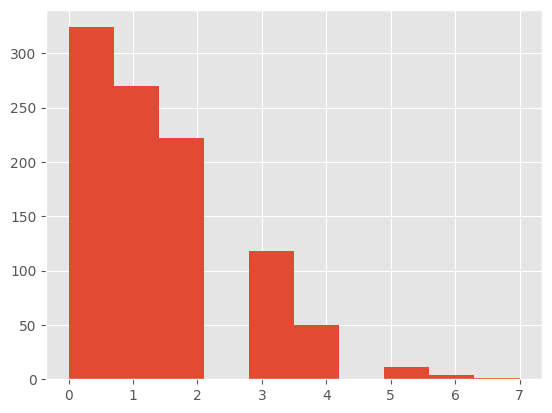

In [19]:
comp = df_comp_details.competition_id.unique()[0]
print(comp)

# filter on first competion_id
df = df_comp_details[df_comp_details.competition_id==comp ]

# concentrate on selling period in [1,20]
# df = df[df.selling_period <= 20 ]
# df = df[df.selling_period <= 20 & df.selling_period <= 40 ]
# df = df[df.selling_period <= 40 & df.selling_period <= 60 ]
# df = df[df.selling_period <= 60 & df.selling_period <= 80 ]
df = df[(df.selling_period > 80) & (df.selling_period <= 100)]

df_train = df[df.selling_season<=50]
df_test = df[df.selling_season>50]

df_train.demand.hist()

Text(0, 0.5, 'Count')

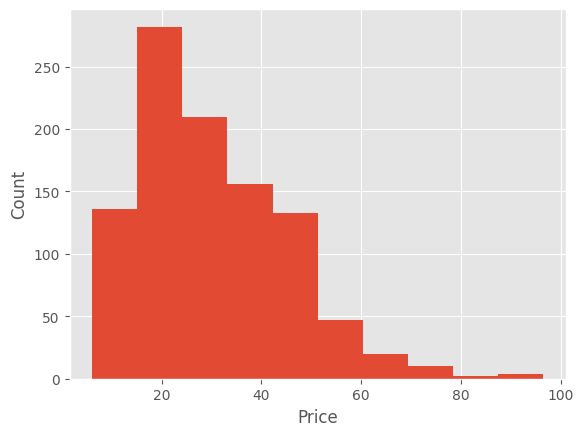

In [20]:
# df_train.head(35)
# df_train.demand.hist()
df_train.price.hist()
plt.xlabel('Price')
plt.ylabel('Count')


Text(0, 0.5, 'Count')

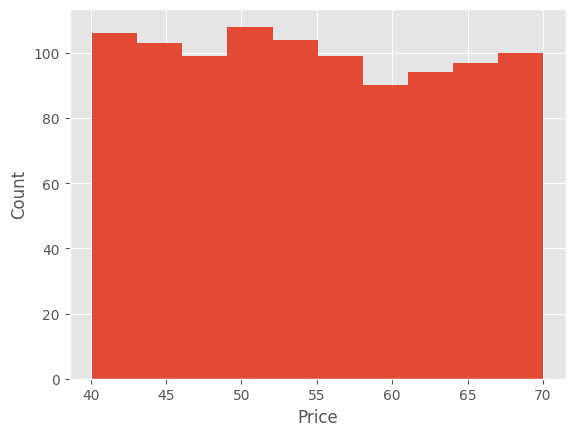

In [21]:
df_train.price_competitor.hist()
plt.xlabel('Price')
plt.ylabel('Count')

## (a) fit OLS model

In [22]:
import statsmodels.api as sm
# https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html

y = df_train.demand

X = df_train[['price', 'price_competitor']]
X['intercept'] = 1


mod = sm.OLS(y, X)
# mod = sm.regression.quantile_regression.QuantReg(y,X)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     33.52
Date:                Tue, 18 Nov 2025   Prob (F-statistic):           8.18e-15
Time:                        08:50:14   Log-Likelihood:                -1638.2
No. Observations:                1000   AIC:                             3282.
Df Residuals:                     997   BIC:                             3297.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
price               -0.0213      0.003  

## (b) predict demand based on function for
- own price = 30
- competitor price = 50

In [23]:
mod.predict(res.params, [30,50,1])

np.float64(1.3187996794797627)

In [24]:
print(res.params)

price              -0.021280
price_competitor    0.008456
intercept           1.534426
dtype: float64


## (c) simulate demand, our prices in [1,100] and competitor_price = 50

In [25]:
def est_demand(price, comp_price, para = res.params):
    demand = para["intercept"] + price*para["price"]+comp_price*para["price_competitor"]
    demand = max(0,demand)
    return demand

df_sim = pd.DataFrame(columns = ['price','demand','rev'])
for p in np.arange(1,100,1):
    demand = est_demand(p,50)
    rev = demand*p
    df_sim.loc[len(df_sim)] = [p,demand,rev]

    
df_sim.head()

,price,demand,rev
0,1.0,1.935929,1.935929
1,2.0,1.914649,3.829298
2,3.0,1.893368,5.680105
3,4.0,1.872088,7.488353
4,5.0,1.850808,9.254039


#### plot demand and revenue curve

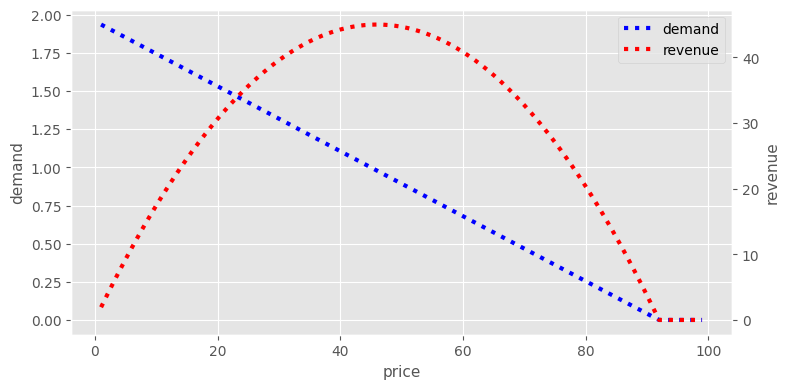

In [26]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(df_sim['price'], df_sim['demand'], color='b', 
        linestyle='dotted', linewidth=3, label='demand')

ax_2 = ax.twinx()
ax_2.grid(False)
ax_2.plot(df_sim['price'], df_sim['rev'], color='r', 
        linestyle='dotted', linewidth=3, label='revenue')

ax_2.tick_params(axis="both", labelsize=10)
ax.tick_params(axis="both", labelsize=10)

# legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_2.get_legend_handles_labels()
ax_2.legend(lines + lines2, labels + labels2, loc=0)

ax.set_xlabel('price', size=11)
ax.set_ylabel("demand" , size=11)
ax_2.set_ylabel("revenue" , size=11)

ax.grid(True)
fig.tight_layout()

plt.show()

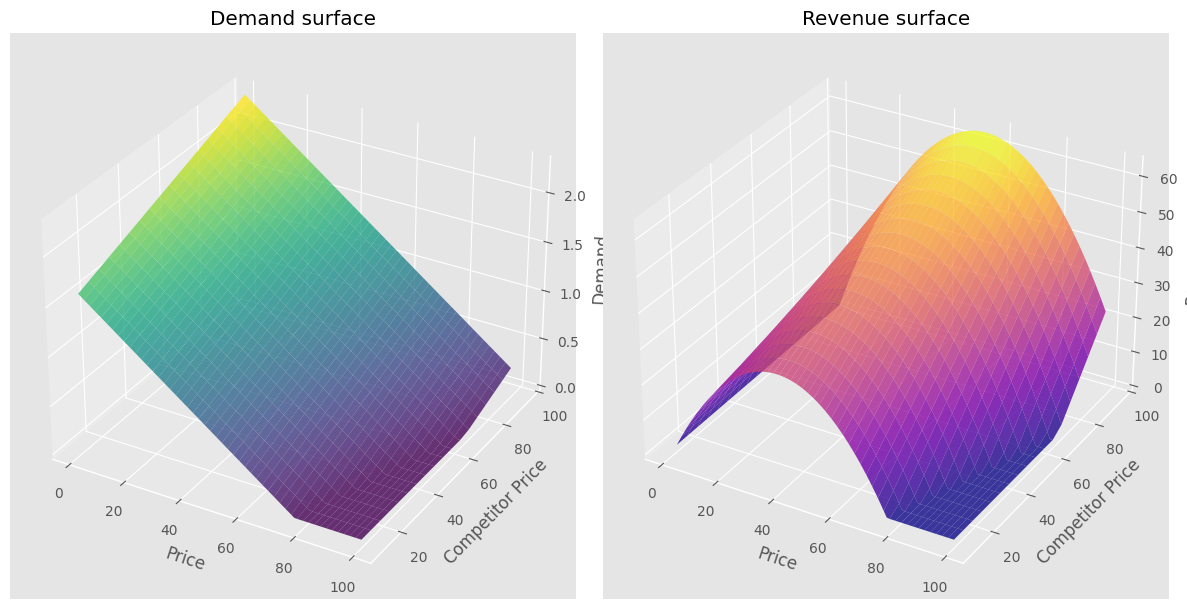

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Fonction de demande ---
def est_demand(price, comp_price, para=res.params):
    demand = para["intercept"] + price*para["price"] + comp_price*para["price_competitor"]
    return np.maximum(0, demand)

# --- Créer une grille de prix et prix concurrent ---
price_range = np.arange(1, 100, 1)
comp_price_range = np.arange(10, 100, 5)

Price, CompPrice = np.meshgrid(price_range, comp_price_range)

# --- Calculer la demande et le revenu sur la grille ---
Demand = est_demand(Price, CompPrice)
Revenue = Demand * Price

# --- Figure 3D ---
fig = plt.figure(figsize=(12, 6))

# Subplot 1 : Demand
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(Price, CompPrice, Demand, cmap='viridis', alpha=0.8)
ax1.set_xlabel("Price")
ax1.set_ylabel("Competitor Price")
ax1.set_zlabel("Demand")
ax1.set_title("Demand surface")

# Subplot 2 : Revenue
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(Price, CompPrice, Revenue, cmap='plasma', alpha=0.8)
ax2.set_xlabel("Price")
ax2.set_ylabel("Competitor Price")
ax2.set_zlabel("Revenue")
ax2.set_title("Revenue surface")

plt.tight_layout()
plt.show()


## (d) compute estimated demand in computation details

In [28]:
df_eval = df_test[['unique_selling_season_key','selling_season','selling_period','price_competitor', 'price', 'demand']]

df_eval.head(5)

,unique_selling_season_key,selling_season,selling_period,price_competitor,price,demand
5080,3fDw3f_51,51,81,44.4,50.1,0
5081,3fDw3f_51,51,82,65.6,50.1,1
5082,3fDw3f_51,51,83,61.5,50.1,2
5083,3fDw3f_51,51,84,51.5,50.2,1
5084,3fDw3f_51,51,85,64.4,50.2,1


In [29]:
# estimate demand
df_eval['est_demand'] = df_eval.apply(lambda r:
            est_demand(price=r['price'], comp_price=r["price_competitor"]),
            axis=1)

# compute error metrics (error = predicted - actual)
df_eval['est_error'] = df_eval['est_demand'] -  df_eval['demand']
df_eval['abs_est_error'] = df_eval['est_error'].abs()

df_eval.head(5)

,unique_selling_season_key,selling_season,selling_period,price_competitor,price,demand,est_demand,est_error,abs_est_error
5080,3fDw3f_51,51,81,44.4,50.1,0,0.843713,0.843713,0.843713
5081,3fDw3f_51,51,82,65.6,50.1,1,1.022974,0.022974,0.022974
5082,3fDw3f_51,51,83,61.5,50.1,2,0.988305,-1.011695,1.011695
5083,3fDw3f_51,51,84,51.5,50.2,1,0.901621,-0.098379,0.098379
5084,3fDw3f_51,51,85,64.4,50.2,1,1.010699,0.010699,0.010699


In [30]:
df_eval[['demand', 'est_demand', 'est_error', 'abs_est_error']].describe()

,demand,est_demand,est_error,abs_est_error
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.279000,1.272169,-0.006831,1.030424
std,1.317154,0.300013,1.280690,0.759853
min,0.000000,0.315285,-5.262684,0.001887
25%,0.000000,1.065155,-0.744481,0.499011
50%,1.000000,1.290621,0.300570,0.889613
75%,2.000000,1.520572,1.000278,1.398954
max,7.000000,1.880866,1.849791,5.262684


### plot the actual demand vs. estimated demand for one test selling season

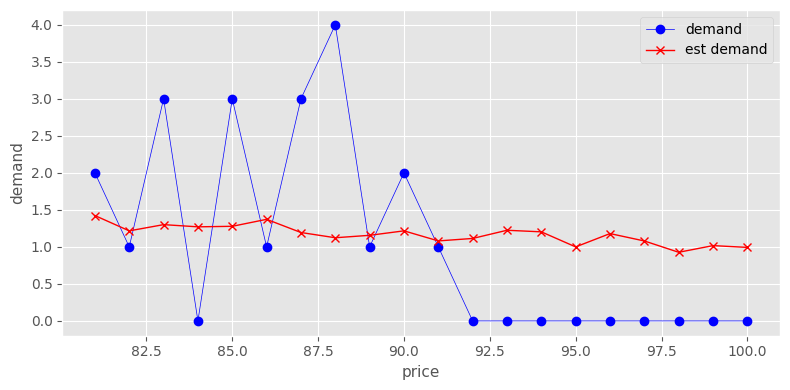

In [31]:
dfe = df_eval[df_eval.selling_season==60]

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(dfe['selling_period'], dfe['demand'], color='b', 
        linestyle='-', marker='o', linewidth=0.5, markersize=6, label='demand')

ax.plot(dfe['selling_period'], dfe['est_demand'], color='r', 
        linestyle='-', marker='x', linewidth=1, markersize=6, label='est demand')

ax.legend( loc=0)

ax.set_xlabel('price', size=11)
ax.set_ylabel("demand" , size=11)

ax.grid(True)
fig.tight_layout()

plt.show()

# next tasks:
## (1) estimate five demand models covering the 100 period selling_season
## (2) estimate demand models for every simulation_id 
## (3) implement the demand model in your own simulation (last week simulation notebook)
## (4) implement the demand model estimation & next price optimization in your pricing algorithm

In [32]:
print(df_comp_details['unique_selling_season_key'].nunique())

400


In [33]:
dem_mean_per_period = df_comp_details.groupby('selling_period').agg({
    'demand' : 'mean'
}).reset_index()
dem_mean_per_period

,selling_period,demand
0,1,0.3700
1,2,0.3125
2,3,0.5100
3,4,0.6650
4,5,0.5100
...,...,...
95,96,0.9925
96,97,0.9675
97,98,1.1700
98,99,0.8300


Text(0, 0.5, 'Mean of demand')

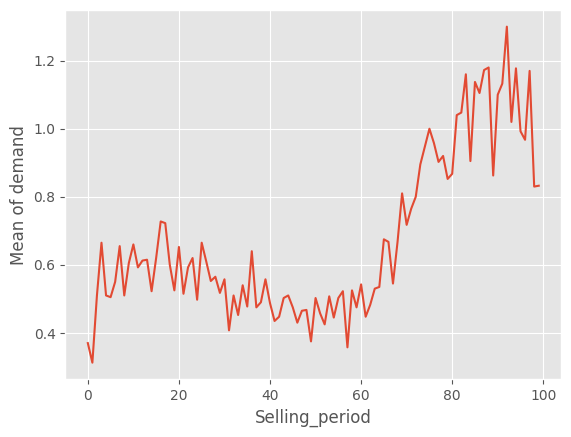

In [34]:
plt.plot(dem_mean_per_period.index, dem_mean_per_period['demand'])
plt.xlabel("Selling_period")
plt.ylabel("Mean of demand")

In [35]:
print(dem_mean_per_period)

    selling_period  demand
0                1  0.3700
1                2  0.3125
2                3  0.5100
3                4  0.6650
4                5  0.5100
..             ...     ...
95              96  0.9925
96              97  0.9675
97              98  1.1700
98              99  0.8300
99             100  0.8325

[100 rows x 2 columns]


--- Regression 1 ---
Periods 1 to 100
Slope (coef) = 0.0058
Intercept = 0.3818
R² = 0.4931



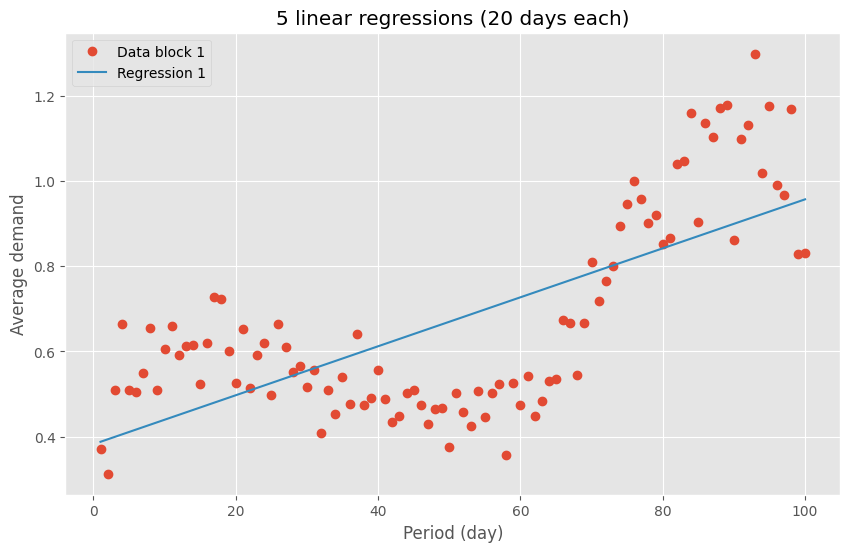

In [36]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

dem_mean_per_period = df_comp_details.groupby('selling_period').agg({
    'demand' : 'mean'
}).reset_index()

# Paramètres
n_regressions = 1
days_per_regression = 100

models = []

plt.figure(figsize=(10, 6))

for i in range(n_regressions):
    # Définir la plage de jours pour cette régression
    start = i * days_per_regression + 1
    end = (i + 1) * days_per_regression
     
    subset = dem_mean_per_period.query("selling_period >= @start and selling_period <= @end")
    
    # Variables d'entrée et de sortie
    X = subset["selling_period"].values.reshape(-1, 1)
    y = subset["demand"].values

    # Régression linéaire
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    models.append(model)
    
    # Affichage console
    print(f"--- Regression {i+1} ---")
    print(f"Periods {start} to {end}")
    print(f"Slope (coef) = {model.coef_[0]:.4f}")
    print(f"Intercept = {model.intercept_:.4f}")
    print(f"R² = {model.score(X, y):.4f}")
    print()
    
    # Tracé
    plt.plot(X, y, 'o', label=f"Data block {i+1}")
    plt.plot(X, y_pred, '-', label=f"Regression {i+1}")

plt.xlabel("Period (day)")
plt.ylabel("Average demand")
plt.title("5 linear regressions (20 days each)")
plt.legend()
plt.show()


In [37]:
# On trace l'évolution de la capacité en fonction de L_quentin

first_selling_season = df_comp_details[df_comp_details['unique_selling_season_key'] == '3fDw3f_1']
first_selling_season['demand_cumsum'] =  first_selling_season['demand'].cumsum()
first_selling_season['capacity'] = (first_selling_season['demand_cumsum'] ) / 80


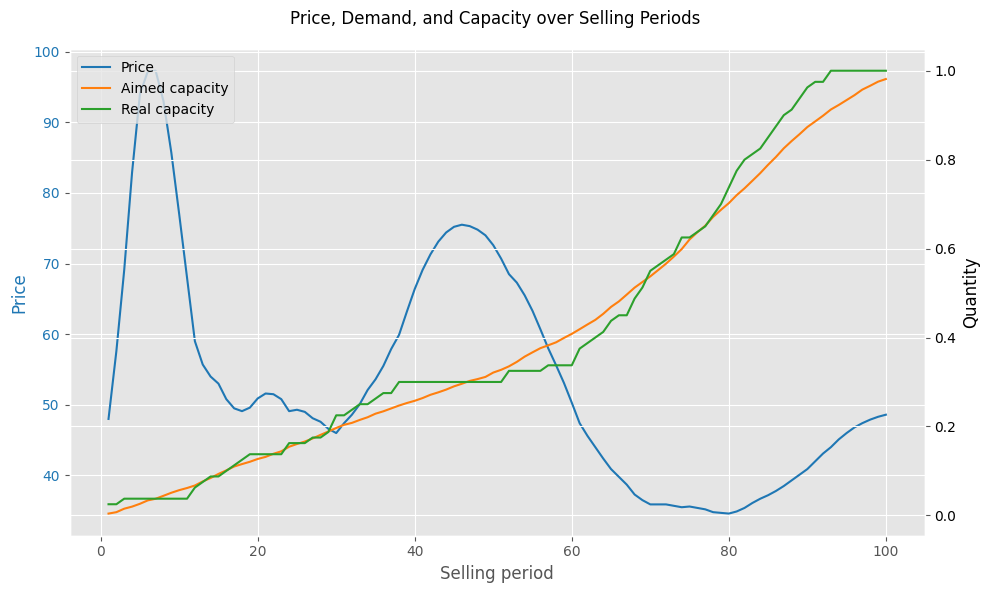

In [38]:
# Create the figure and the main axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# --- Left axis: Price ---
color = 'tab:blue'
ax1.set_xlabel("Selling period")
ax1.set_ylabel("Price", color=color)
ax1.plot(first_selling_season['selling_period'], first_selling_season['price'], color=color, label="Price")
ax1.tick_params(axis='y', labelcolor=color)

# --- Right axis: Demand and Capacity ---
ax2 = ax1.twinx()  # create a twin axis sharing the same x-axis

color_demand = 'tab:orange'
color_capacity = 'tab:green'
ax2.set_ylabel("Quantity", color='black')
ax2.plot(first_selling_season['selling_period'], L_quentin, color=color_demand, label="Aimed capacity")
ax2.plot(first_selling_season['selling_period'], first_selling_season['capacity'], color=color_capacity, label="Real capacity")
ax2.tick_params(axis='y', labelcolor='black')

# --- Titles and legend ---
fig.suptitle("Price, Demand, and Capacity over Selling Periods")

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()
